# ***Import the dataset***

In [ ]:
import zipfile

with zipfile.ZipFile('/content/online+retail+ii.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import pandas as pd

# Load both yearly sheets into a single DataFrame
file_path = "online_retail_II.xlsx"
sheets = pd.ExcelFile(file_path).sheet_names
df_list = [pd.read_excel(file_path, sheet_name=s) for s in sheets]
df = pd.concat(df_list, ignore_index=True)

# **Look at the Data Set**

In [ ]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:

print("Shape:", df.shape)

Shape: (1067371, 8)


In [ ]:
print("\nColumns:", df.columns.tolist())


Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


In [ ]:
# --- Harmonise column names -----------------------------------------------
df.columns = df.columns.str.strip()            # remove any trailing spaces
if 'Price' in df.columns and 'UnitPrice' not in df.columns:
    df = df.rename(columns={'Price': 'UnitPrice'})


In [ ]:
print("\nDescriptive statistics (Quantity & UnitPrice):\n",
      df[['Quantity', 'UnitPrice']].describe())



Descriptive statistics (Quantity & UnitPrice):
            Quantity     UnitPrice
count  1.067371e+06  1.067371e+06
mean   9.938898e+00  4.649388e+00
std    1.727058e+02  1.235531e+02
min   -8.099500e+04 -5.359436e+04
25%    1.000000e+00  1.250000e+00
50%    3.000000e+00  2.100000e+00
75%    1.000000e+01  4.150000e+00
max    8.099500e+04  3.897000e+04


In [ ]:
df['Sales'] = df['Quantity'] * df['UnitPrice']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


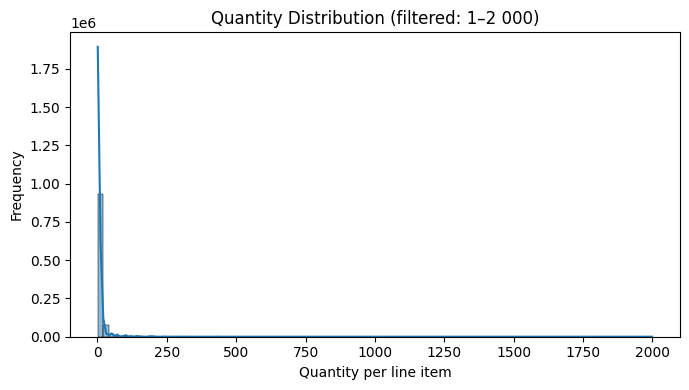

In [ ]:
#  filter out cancellations & extreme outliers
df_clean = df[(~df['Invoice'].astype(str).str.startswith('C')) &   # drop cancels
              (df['Quantity'].between(1, 2000))]                  # keep reasonable range

#   plot with smaller bins or a log x-axis
plt.figure(figsize=(7,4))
sns.histplot(df_clean['Quantity'], bins=100, kde=True)
plt.title("Quantity Distribution (filtered: 1–2 000)")
plt.xlabel("Quantity per line item")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

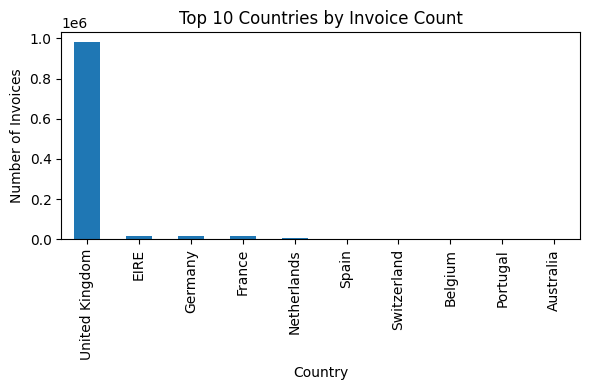

In [ ]:
# Top 10 countries by transaction count
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(6,4))
top_countries.plot(kind='bar')
plt.title("Top 10 Countries by Invoice Count")
plt.xlabel("Country")
plt.ylabel("Number of Invoices")
plt.tight_layout()
plt.show()

In [ ]:
df['UnitPrice'].describe(percentiles=[.99, .999])


,UnitPrice
count,1.067371e+06
mean,4.649388e+00
std,1.235531e+02
min,-5.359436e+04
50%,2.100000e+00
99%,1.800000e+01
99.9%,2.170160e+02
max,3.897000e+04


Negative prices removed : 6,207
> 99.9th-pct prices kept : 1,062  (plotted separately with log scale)
Main distribution count : 1,060,102


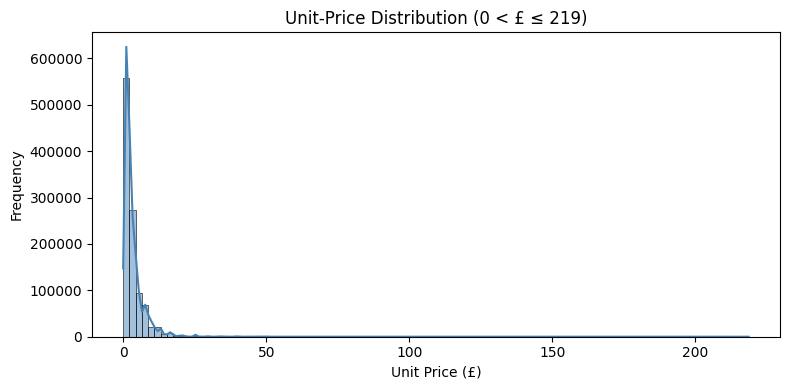

In [ ]:

# ---FILTER BAD / EXTREME VALUES ----------------
# drop negatives
df_pos  = df[df['UnitPrice'] > 0].copy()

# cap at the 99.9th percentile (≈ £217)
upper   = df_pos['UnitPrice'].quantile(0.999)
df_main = df_pos[df_pos['UnitPrice'] <= upper]

print(f"Negative prices removed : {(df['UnitPrice']<=0).sum():,}")
print(f"> 99.9th-pct prices kept : {(df_pos['UnitPrice']>upper).sum():,}  (plotted separately with log scale)")
print(f"Main distribution count : {len(df_main):,}")

# ---   PLOT MAIN RANGE (0–{upper:,.0f}) ------------
plt.figure(figsize=(8,4))
sns.histplot(df_main['UnitPrice'],
             bins=100, kde=True, color='steelblue')
plt.title(f"Unit-Price Distribution (0 < £ ≤ {upper:,.0f})")
plt.xlabel("Unit Price (£)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()



# **Preprocessing**

In [ ]:
# 3. handle prices
df           = df[df['UnitPrice'] > 0]                         # remove negative/zero
upper        = df['UnitPrice'].quantile(0.999)                 # cap extreme 0.1 %
df['UnitPrice'] = df['UnitPrice'].clip(upper=upper)


In [ ]:

# 4. fill missing IDs
df['Customer ID'] = df['Customer ID'].fillna('Guest')


In [ ]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Customer ID,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,14.85


# **Preprocessing**

In [ ]:
# ---- basic cleaning ------------------------------------------------------
df['Invoice']    = df['Invoice'].astype(str).str.strip()
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
df['StockCode']  = df['StockCode'].astype(str).str.strip()

# drop cancellations & negatives
df = df[~df['Invoice'].str.startswith('C')]
df = df[df['Quantity'] > 0]

# fix price column name if needed
if 'Price' in df.columns and 'UnitPrice' not in df.columns:
    df = df.rename(columns={'Price':'UnitPrice'})

# remove zero/negative/abnormal prices
df = df[df['UnitPrice'] > 0]
upper = df['UnitPrice'].quantile(0.999)
df['UnitPrice'] = df['UnitPrice'].clip(upper=upper)

# fill missing customer
df['Customer ID'] = df['Customer ID'].fillna('Guest')

# add helpers
df['Sales']   = df['Quantity'] * df['UnitPrice']
df['Date']    = df['InvoiceDate'].dt.date
df['Month']   = df['InvoiceDate'].dt.month
df['Year']    = df['InvoiceDate'].dt.year
print(df.shape, "rows after cleaning")

(1041670, 12) rows after cleaning


In [ ]:



import pandas as pd
import numpy as np
import holidays
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, itertools, datetime as dt, tensorflow as tf
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")


# **Aggregate to daily SKU demand**

In [ ]:
daily = (df.groupby(['Date','StockCode'])
           .agg(Quantity=('Quantity','sum'),
                Sales=('Sales','sum'))
           .reset_index())

# choose ONE example SKU to illustrate modelling
example_sku = daily['StockCode'].value_counts().idxmax()
sku_df      = daily[daily['StockCode']==example_sku].copy()

# re-index to continuous dates; missing days → 0 demand
rng         = pd.date_range(sku_df['Date'].min(), sku_df['Date'].max(), freq='D')
sku_df      = (sku_df.set_index('Date')
                      .reindex(rng)
                      .fillna(0)
                      .rename_axis('ds')
                      .reset_index()
                      .rename(columns={'Quantity':'y'}))

print(sku_df.head())


          ds StockCode      y    Sales
0 2009-12-01    85123A  261.0   702.42
1 2009-12-02    85123A  750.0  1953.99
2 2009-12-03    85123A  359.0   988.43
3 2009-12-04    85123A  179.0   489.65
4 2009-12-05    85123A   96.0   249.60


# **Feature engineering for tree/LSTM models**

In [ ]:
import holidays
def create_features(df, lags=[1,2,3,7,14,28]):
    out = df.copy()
    # calendar
    out['dayofweek'] = out['ds'].dt.dayofweek
    out['month']     = out['ds'].dt.month
    out['year']      = out['ds'].dt.year
    # UK holiday flag
    uk_holidays = holidays.UnitedKingdom()
    out['holiday'] = out['ds'].isin(uk_holidays).astype(int)
    # lag features
    for l in lags:
        out[f'lag_{l}'] = out['y'].shift(l)
    # rolling
    out['rolling_7']  = out['y'].rolling(7).mean()
    out['rolling_30'] = out['y'].rolling(30).mean()
    return out.dropna()

sku_feat = create_features(sku_df)


# **Train-test split**

In [ ]:
train_size = int(len(sku_feat)*0.8)
train, test = sku_feat.iloc[:train_size], sku_feat.iloc[train_size:]
X_train, y_train = train.drop(['y','ds'], axis=1), train['y']
X_test,  y_test  = test.drop(['y','ds'], axis=1),  test['y']


In [ ]:
def evaluate_model(y_true, y_pred):
    """
    Calculates RMSE, MAE, and MSE for given true and predicted values.

    Args:
        y_true: The actual values.
        y_pred: The predicted values.

    Returns:
        A tuple containing RMSE, MAE, and MSE.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae, mse

# **SARIMA**

In [ ]:
# quick grid-search (tiny)
p=d=q=range(0,2)
pdq    = list(itertools.product(p, d, q))
best_mse, best_order = np.inf, None
for order in pdq:
    try:
        model = SARIMAX(train['y'], order=order, seasonal_order=(1,1,1,7)).fit(disp=False)
        mse   = mean_squared_error(test['y'], model.forecast(len(test)))
        if mse < best_mse:
            best_mse, best_order = mse, order
    except: pass

import time
start_time = time.time()
sarima = SARIMAX(train['y'], order=best_order, seasonal_order=(1,1,1,7)).fit(disp=False)
training_time = time.time() - start_time

start_time = time.time()
sar_pred = sarima.forecast(len(test))
testing_time = time.time() - start_time

print("SARIMA Training Time:", training_time, "seconds")
print("SARIMA Testing Time:", testing_time, "seconds")
print("SARIMA RMSE:", np.sqrt(mean_squared_error(test['y'], sar_pred)))

SARIMA Training Time: 0.7424049377441406 seconds
SARIMA Testing Time: 0.010984182357788086 seconds
SARIMA RMSE: 128.48117289212166


In [ ]:
sarima_rmse, sarima_mae, sarima_mse = evaluate_model(test['y'], sar_pred)
print(f"SARIMA RMSE: {sarima_rmse:.4f}")
print(f"SARIMA MAE:  {sarima_mae:.4f}")
print(f"SARIMA MSE:  {sarima_mse:.4f}")

SARIMA RMSE: 128.4812
SARIMA MAE:  75.4683
SARIMA MSE:  16507.4118


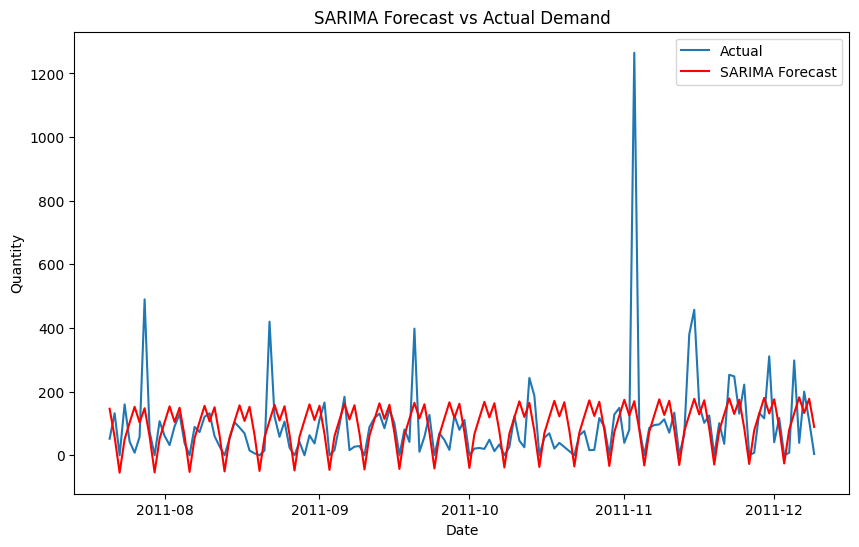

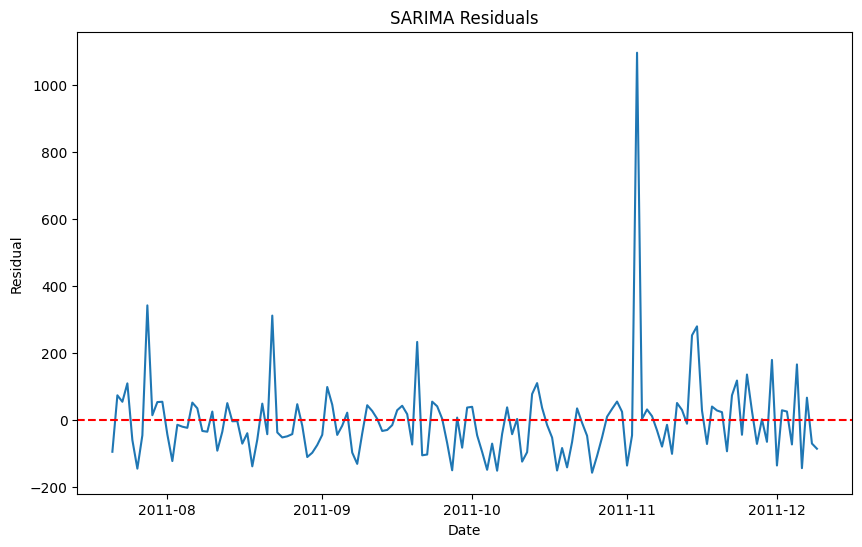

In [ ]:
# Forecast plot (actual vs. predicted)
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], sar_pred, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast vs Actual Demand')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Residual plot
residuals = test['y'] - sar_pred.values
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], residuals)
plt.title('SARIMA Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# **Prophet**

In [ ]:
import time
start_time = time.time()
prop = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
prop.fit(train[['ds','y']].rename(columns={'ds':'ds','y':'y'}))
training_time = time.time() - start_time

start_time = time.time()
future  = test[['ds']].rename(columns={'ds':'ds'})
prop_fc = prop.predict(future)['yhat'].values
testing_time = time.time() - start_time

print("Prophet Training Time:", training_time, "seconds")
print("Prophet Testing Time:", testing_time, "seconds")
print("Prophet RMSE:", np.sqrt(mean_squared_error(test['y'], prop_fc)))

DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3b69ts7/6wki9uc0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3b69ts7/wpfvlalq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8695', 'data', 'file=/tmp/tmpl3b69ts7/6wki9uc0.json', 'init=/tmp/tmpl3b69ts7/wpfvlalq.json', 'output', 'file=/tmp/tmpl3b69ts7/prophet_modelhco9lvym/prophet_model-20250813094151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:41:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:41:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Training Time: 0.12115621566772461 seconds
Prophet Testing Time: 0.06945514678955078 seconds
Prophet RMSE: 144.88263611741465


In [ ]:
prop_rmse, prop_mae, prop_mse = evaluate_model(test['y'], prop_fc)
print(f"Prophet RMSE: {prop_rmse:.4f}")
print(f"Prophet MAE:  {prop_mae:.4f}")
print(f"Prophet MSE:  {prop_mse:.4f}")

Prophet RMSE: 144.8826
Prophet MAE:  94.5631
Prophet MSE:  20990.9782


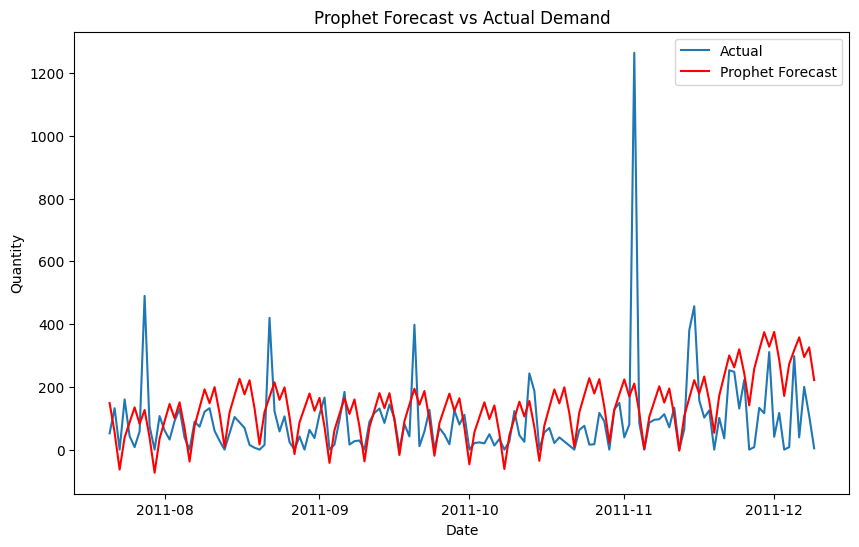

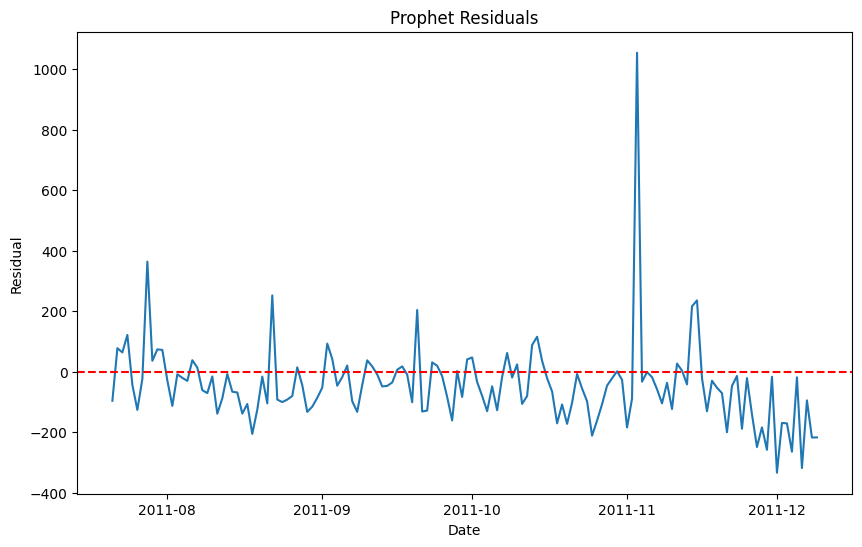

In [ ]:
# Forecast plot (actual vs. predicted)
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], prop_fc, label='Prophet Forecast', color='red')
plt.title('Prophet Forecast vs Actual Demand')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Residual plot
residuals = test['y'] - prop_fc
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], residuals)
plt.title('Prophet Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# **XGBoost**

In [ ]:
# scale numeric features
scaler   = StandardScaler()
X_train_s= scaler.fit_transform(X_train.drop('StockCode', axis=1))
X_test_s = scaler.transform(X_test.drop('StockCode', axis=1))

import time
start_time = time.time()
xg_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05,
                            max_depth=6, subsample=0.8,
                            objective='reg:squarederror', random_state=42)
xg_model.fit(X_train_s, y_train,
             eval_set=[(X_test_s, y_test)],
             verbose=False)
training_time = time.time() - start_time

start_time = time.time()
xg_pred  = xg_model.predict(X_test_s)
testing_time = time.time() - start_time

print("XGBoost Training Time:", training_time, "seconds")
print("XGBoost Testing Time:", testing_time, "seconds")
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, xg_pred)))

XGBoost Training Time: 1.0371284484863281 seconds
XGBoost Testing Time: 0.004031181335449219 seconds
XGBoost RMSE: 11.443460101652269


In [ ]:
xg_rmse, xg_mae, xg_mse = evaluate_model(y_test, xg_pred)
print(f"XGBoost RMSE: {xg_rmse:.4f}")
print(f"XGBoost MAE:  {xg_mae:.4f}")
print(f"XGBoost MSE:  {xg_mse:.4f}")

XGBoost RMSE: 11.4435
XGBoost MAE:  4.5849
XGBoost MSE:  130.9528


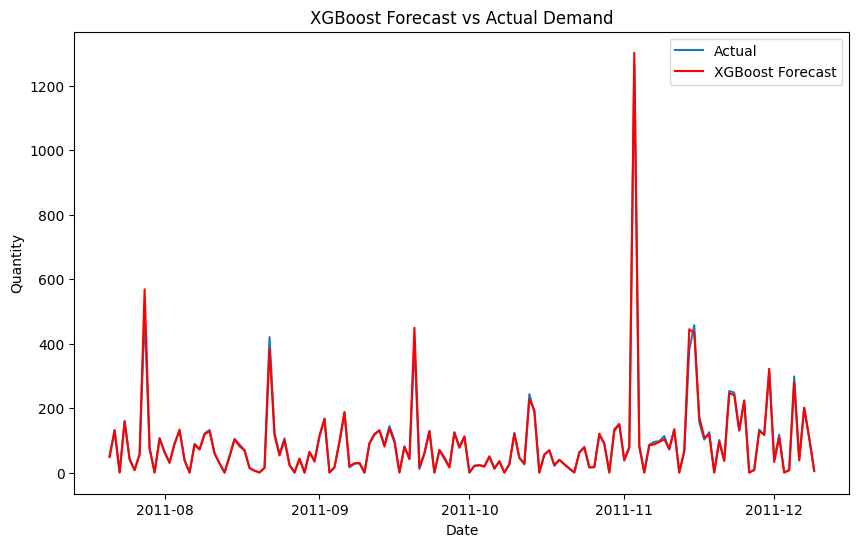

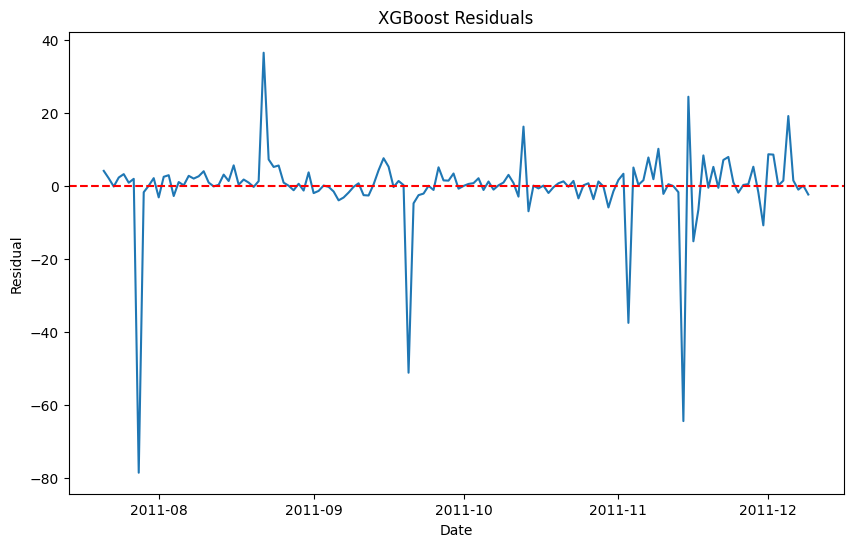

In [ ]:
# Forecast plot (actual vs. predicted)
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(test['ds'], xg_pred, label='XGBoost Forecast', color='red')
plt.title('XGBoost Forecast vs Actual Demand')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Residual plot
residuals = test['y'] - xg_pred
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], residuals)
plt.title('XGBoost Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()

 # **LSTM**

In [ ]:
# reshape to [samples, timesteps, features]
seq_len = 30   # last 30 days used to predict next day
def make_sequences(df, seq_len=30):
    x, y = [], []
    for i in range(seq_len, len(df)):
        x.append(df.iloc[i-seq_len:i][['y']].values)
        y.append(df.iloc[i]['y'])
    return np.array(x), np.array(y)

lstm_train, lstm_test = sku_df.iloc[:train_size+30], sku_df.iloc[train_size:]

import time
start_time = time.time()
X_lstm_tr, y_lstm_tr  = make_sequences(lstm_train, seq_len)
X_lstm_te, y_lstm_te  = make_sequences(pd.concat([lstm_train.iloc[-seq_len:], lstm_test]), seq_len)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_len,1)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)
])
model.compile(loss='mse', optimizer='adam')
model.fit(X_lstm_tr, y_lstm_tr, epochs=30, batch_size=32,
          validation_split=0.1, verbose=0)
training_time = time.time() - start_time

start_time = time.time()
lstm_pred = model.predict(X_lstm_te).flatten()
testing_time = time.time() - start_time

print("LSTM Training Time:", training_time, "seconds")
print("LSTM Testing Time:", testing_time, "seconds")
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_lstm_te, lstm_pred)))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
LSTM Training Time: 23.19979453086853 seconds
LSTM Testing Time: 0.6894502639770508 seconds
LSTM RMSE: 152.0874637474227


In [ ]:
lstm_rmse, lstm_mae, lstm_mse = evaluate_model(y_lstm_te, lstm_pred)
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE:  {lstm_mae:.4f}")
print(f"LSTM MSE:  {lstm_mse:.4f}")

LSTM RMSE: 152.2719
LSTM MAE:  76.4629
LSTM MSE:  23186.7174


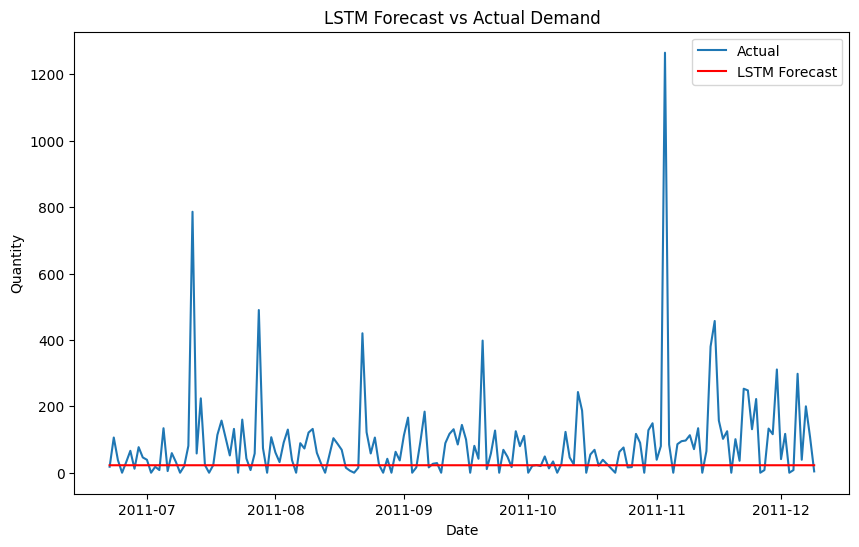

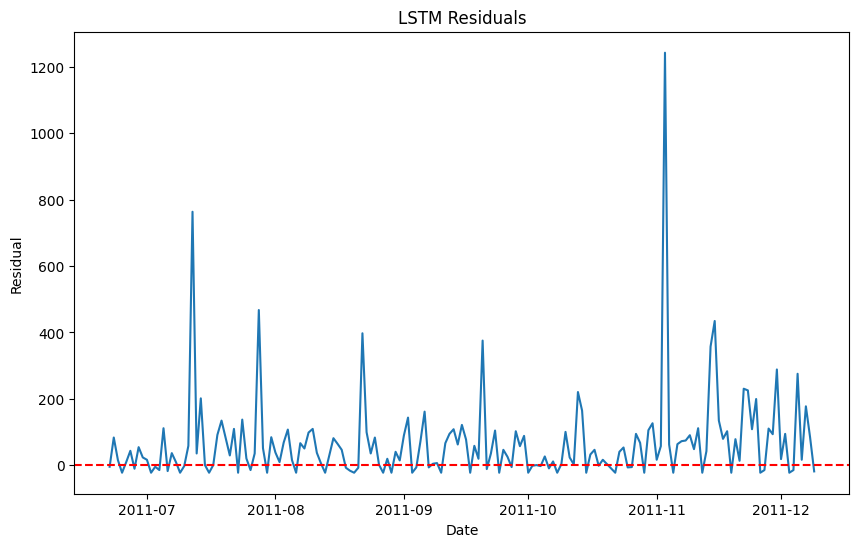

In [ ]:
# Forecast plot (actual vs. predicted)
plt.figure(figsize=(10, 6))
plt.plot(sku_df['ds'].iloc[train_size : train_size + len(y_lstm_te)].reset_index(drop=True), y_lstm_te, label='Actual')
plt.plot(sku_df['ds'].iloc[train_size : train_size + len(y_lstm_te)].reset_index(drop=True), lstm_pred, label='LSTM Forecast', color='red')
plt.title('LSTM Forecast vs Actual Demand')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Residual plot
residuals = y_lstm_te - lstm_pred
plt.figure(figsize=(10, 6))
plt.plot(sku_df['ds'].iloc[train_size : train_size + len(y_lstm_te)].reset_index(drop=True), residuals, label='Residuals')
plt.title('LSTM Residuals')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.axhline(0, color='red', linestyle='--')
plt.show()

## Feature engineering for clustering



In [ ]:
# 1. Calculate total quantity and total sales for each StockCode
sku_summary = df.groupby('StockCode').agg(
    TotalQuantity=('Quantity', 'sum'),
    TotalSales=('Sales', 'sum')
).reset_index()

# 2. Calculate the number of unique invoices for each StockCode
invoice_counts = df.groupby('StockCode')['Invoice'].nunique().reset_index(name='InvoiceCount')

# 3. Calculate the average unit price for each StockCode
avg_unit_price = df.groupby('StockCode')['UnitPrice'].mean().reset_index(name='AverageUnitPrice')

# 4. Merge these calculated features into a new DataFrame
sku_features = sku_summary.merge(invoice_counts, on='StockCode')
sku_features = sku_features.merge(avg_unit_price, on='StockCode')

# 5. Handle any missing values - although aggregation should not create NaNs here, it's good practice to check
sku_features = sku_features.fillna(0)

display(sku_features.head())

,StockCode,TotalQuantity,TotalSales,InvoiceCount,AverageUnitPrice
0,10002,8836,7097.90,362,0.987801
1,10002R,4,20.57,3,5.133333
2,10080,315,129.29,27,0.505000
3,10109,4,1.68,1,0.420000
4,10120,680,146.10,73,0.238571


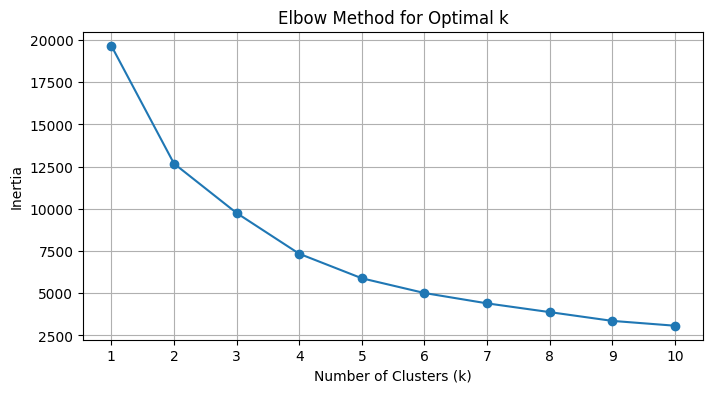

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Extract features for clustering (excluding 'StockCode')
X_cluster = sku_features.drop('StockCode', axis=1)

# Scale the features
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_cluster)

# Elbow method: Calculate inertia for different numbers of clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow method results
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()


**Reasoning**:
Calculate and plot the silhouette scores for different numbers of clusters to help determine the optimal number of clusters.



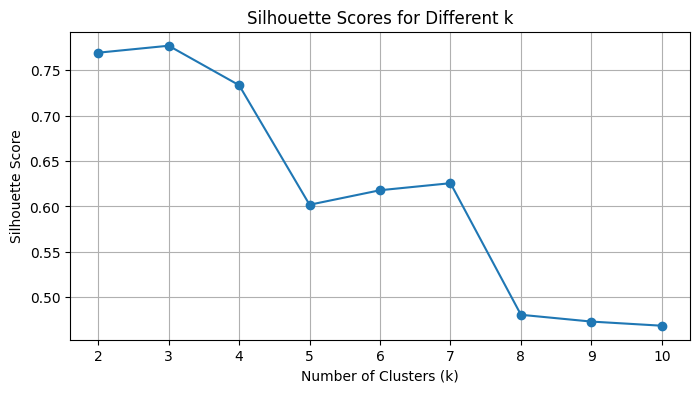

In [ ]:
# Silhouette method: Calculate silhouette score for different numbers of clusters
silhouette_scores = []
k_range_silhouette = range(2, 11) # Silhouette score requires at least 2 clusters
for k in k_range_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_range_silhouette, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.show()

## Perform k-means clustering

### Subtask:
Apply the k-means algorithm to the product data to create clusters.


In [ ]:
# Choose the number of clusters (based on previous analysis)
n_clusters = 3

# Initialize and fit KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(X_scaled)

# Assign cluster labels back to the original dataframe
sku_features['ClusterLabel'] = kmeans.labels_

# Display the first few rows with the new cluster labels
display(sku_features.head())

,StockCode,TotalQuantity,TotalSales,InvoiceCount,AverageUnitPrice,ClusterLabel
0,10002,8836,7097.90,362,0.987801,0
1,10002R,4,20.57,3,5.133333,0
2,10080,315,129.29,27,0.505000,0
3,10109,4,1.68,1,0.420000,0
4,10120,680,146.10,73,0.238571,0


In [ ]:
sku_features

,StockCode,TotalQuantity,TotalSales,InvoiceCount,AverageUnitPrice,ClusterLabel
0,10002,8836,7097.90,362,0.987801,0
1,10002R,4,20.57,3,5.133333,0
2,10080,315,129.29,27,0.505000,0
3,10109,4,1.68,1,0.420000,0
4,10120,680,146.10,73,0.238571,0
...,...,...,...,...,...,...
4911,gift_0001_40,5,166.09,5,33.218000,0
4912,gift_0001_50,6,253.59,6,42.265000,0
4913,gift_0001_70,1,59.57,1,59.570000,2
4914,gift_0001_80,1,69.56,1,69.560000,2


## ***Train models per cluster***



In [ ]:
cluster_labels = sku_features['ClusterLabel'].unique()

trained_models = {}
predictions = {}

for cluster in cluster_labels:
    print(f"\nProcessing Cluster {cluster}")

    # a. Filter data for the current cluster
    cluster_skus = sku_features[sku_features['ClusterLabel'] == cluster]['StockCode'].tolist()
    df_cluster = df[df['StockCode'].isin(cluster_skus)].copy()

    # b. Aggregate to daily SKU demand
    daily_cluster = (df_cluster.groupby(['Date', 'StockCode'])
                       .agg(Quantity=('Quantity', 'sum'),
                            Sales=('Sales', 'sum'))
                       .reset_index())

    # For simplicity and to avoid issues with Prophet/SARIMA on multiple time series,
    # we will train models on the aggregated daily quantity for the *entire* cluster
    # instead of individual SKUs within the cluster.
    daily_cluster_agg = (daily_cluster.groupby('Date')
                                      .agg(Quantity=('Quantity', 'sum'))
                                      .reset_index())

    # Re-index to continuous dates
    rng_cluster = pd.date_range(daily_cluster_agg['Date'].min(), daily_cluster_agg['Date'].max(), freq='D')
    sku_df_cluster = (daily_cluster_agg.set_index('Date')
                                       .reindex(rng_cluster)
                                       .fillna(0)
                                       .rename_axis('ds')
                                       .reset_index()
                                       .rename(columns={'Quantity': 'y'}))


    # c. Create features for tree/LSTM models
    sku_feat_cluster = create_features(sku_df_cluster)

    # d. Split into training and testing sets
    train_size_cluster = int(len(sku_feat_cluster) * 0.8)
    train_cluster, test_cluster = sku_feat_cluster.iloc[:train_size_cluster], sku_feat_cluster.iloc[train_size_cluster:]
    # Fix: Remove 'StockCode' from the columns to drop as it's not in sku_feat_cluster
    X_train_cluster, y_train_cluster = train_cluster.drop(['y', 'ds'], axis=1), train_cluster['y']
    X_test_cluster, y_test_cluster = test_cluster.drop(['y', 'ds'], axis=1), test_cluster['y']

    # e. Train SARIMA model
    # Using the previously found best order for simplicity and computational efficiency
    try:
        sarima_cluster = SARIMAX(train_cluster['y'], order=best_order, seasonal_order=(1, 1, 1, 7)).fit(disp=False)
        sar_pred_cluster = sarima_cluster.forecast(len(test_cluster))
        predictions[f'cluster_{cluster}_sarima'] = sar_pred_cluster
    except Exception as e:
        print(f"SARIMA training failed for cluster {cluster}: {e}")
        predictions[f'cluster_{cluster}_sarima'] = None


    # f. Train Prophet model
    try:
        prop_cluster = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        prop_cluster.fit(train_cluster[['ds', 'y']].rename(columns={'ds': 'ds', 'y': 'y'}))
        future_cluster = test_cluster[['ds']].rename(columns={'ds': 'ds'})
        prop_fc_cluster = prop_cluster.predict(future_cluster)['yhat'].values
        predictions[f'cluster_{cluster}_prophet'] = prop_fc_cluster
    except Exception as e:
        print(f"Prophet training failed for cluster {cluster}: {e}")
        predictions[f'cluster_{cluster}_prophet'] = None


    # g. Scale features for XGBoost and LSTM
    scaler_cluster_models = StandardScaler()
    X_train_scaled_cluster = scaler_cluster_models.fit_transform(X_train_cluster)
    X_test_scaled_cluster = scaler_cluster_models.transform(X_test_cluster)


    # h. Train XGBoost model
    try:
        xg_model_cluster = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05,
                                            max_depth=6, subsample=0.8,
                                            objective='reg:squarederror', random_state=42)
        xg_model_cluster.fit(X_train_scaled_cluster, y_train_cluster,
                             eval_set=[(X_test_scaled_cluster, y_test_cluster)],
                             verbose=False)
        xg_pred_cluster = xg_model_cluster.predict(X_test_scaled_cluster)
        predictions[f'cluster_{cluster}_xgboost'] = xg_pred_cluster
    except Exception as e:
        print(f"XGBoost training failed for cluster {cluster}: {e}")
        predictions[f'cluster_{cluster}_xgboost'] = None


    # i. Prepare data for LSTM
    # Need to include the 'y' column for make_sequences
    lstm_train_cluster = sku_df_cluster.iloc[:train_size_cluster + seq_len].copy()
    lstm_test_cluster_full = pd.concat([sku_df_cluster.iloc[train_size_cluster - seq_len:train_size_cluster], sku_df_cluster.iloc[train_size_cluster:]]).copy()


    # j. Train LSTM model
    try:
        X_lstm_tr_cluster, y_lstm_tr_cluster = make_sequences(lstm_train_cluster, seq_len)
        X_lstm_te_cluster, y_lstm_te_cluster = make_sequences(lstm_test_cluster_full, seq_len)

        model_cluster = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(seq_len, 1)),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.LSTM(32),
            tf.keras.layers.Dense(1)
        ])
        model_cluster.compile(loss='mse', optimizer='adam')
        model_cluster.fit(X_lstm_tr_cluster, y_lstm_tr_cluster, epochs=30, batch_size=32,
                          validation_split=0.1, verbose=0)
        lstm_pred_cluster = model_cluster.predict(X_lstm_te_cluster).flatten()
        predictions[f'cluster_{cluster}_lstm'] = lstm_pred_cluster
    except Exception as e:
        print(f"LSTM training failed for cluster {cluster}: {e}")
        predictions[f'cluster_{cluster}_lstm'] = None

    # Store the actual values for evaluation
    predictions[f'cluster_{cluster}_actual'] = y_test_cluster.values
    predictions[f'cluster_{cluster}_actual_lstm'] = y_lstm_te_cluster



Processing Cluster 0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3b69ts7/td6yau4s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3b69ts7/88qh2fv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45738', 'data', 'file=/tmp/tmpl3b69ts7/td6yau4s.json', 'init=/tmp/tmpl3b69ts7/88qh2fv5.json', 'output', 'file=/tmp/tmpl3b69ts7/prophet_modelwug_yfbq/prophet_model-20250813140924.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step

Processing Cluster 1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3b69ts7/6du0jpa0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3b69ts7/p9_zacg0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69887', 'data', 'file=/tmp/tmpl3b69ts7/6du0jpa0.json', 'init=/tmp/tmpl3b69ts7/p9_zacg0.json', 'output', 'file=/tmp/tmpl3b69ts7/prophet_model6ttnxelo/prophet_model-20250813141007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

Processing Cluster 2


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3b69ts7/fnta2pkx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl3b69ts7/twzhzn9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86750', 'data', 'file=/tmp/tmpl3b69ts7/fnta2pkx.json', 'init=/tmp/tmpl3b69ts7/twzhzn9w.json', 'output', 'file=/tmp/tmpl3b69ts7/prophet_modelcfbb_gn9/prophet_model-20250813141039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:10:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:10:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step


In [ ]:
cluster_eval_results = {}

for cluster in cluster_labels:
    print(f"Evaluating Cluster {cluster}")
    actual_values = predictions.get(f'cluster_{cluster}_actual')
    actual_values_lstm = predictions.get(f'cluster_{cluster}_actual_lstm')


    for model in ['sarima', 'prophet', 'xgboost', 'lstm']:
        predicted_values = predictions.get(f'cluster_{cluster}_{model}')

        if predicted_values is not None:
            # Use the correct actual values based on the model type
            if model == 'lstm':
                 rmse, mae, mse = evaluate_model(actual_values_lstm, predicted_values)
            else:
                 rmse, mae, mse = evaluate_model(actual_values, predicted_values)


            cluster_eval_results[f'cluster_{cluster}_{model}_metrics'] = {
                'RMSE': rmse,
                'MAE': mae,
                'MSE': mse
            }
        else:
            cluster_eval_results[f'cluster_{cluster}_{model}_metrics'] = {
                'RMSE': None,
                'MAE': None,
                'MSE': None
            }

print("\nCluster Evaluation Results:")
for cluster_model, metrics in cluster_eval_results.items():
    print(f"{cluster_model}: {metrics}")

Evaluating Cluster 0
Evaluating Cluster 1
Evaluating Cluster 2

Cluster Evaluation Results:
cluster_0_sarima_metrics: {'RMSE': np.float64(4932.013202960013), 'MAE': 3994.7039645784666, 'MSE': 24324754.234171886}
cluster_0_prophet_metrics: {'RMSE': np.float64(5211.394839492023), 'MAE': 4280.65985701301, 'MSE': 27158636.173084084}
cluster_0_xgboost_metrics: {'RMSE': np.float64(3919.9368341688296), 'MAE': 2818.5413818779125, 'MSE': 15365904.783873545}
cluster_0_lstm_metrics: {'RMSE': np.float64(12755.64512797881), 'MAE': 10646.645587876526, 'MSE': 162706482.6309296}
cluster_1_sarima_metrics: {'RMSE': np.float64(7458.555524151928), 'MAE': 3549.122482484378, 'MSE': 55630050.50685724}
cluster_1_prophet_metrics: {'RMSE': np.float64(7332.231246461443), 'MAE': 3717.282479276707, 'MSE': 53761615.05158553}
cluster_1_xgboost_metrics: {'RMSE': np.float64(6848.833515499191), 'MAE': 3222.573555590401, 'MSE': 46906520.523025006}
cluster_1_lstm_metrics: {'RMSE': np.float64(11264.76929051786), 'MAE': 80

In [ ]:
import pandas as pd
import numpy as np

# 1. Create a new dictionary to store the aggregated performance metrics for the clustered approach.
aggregated_cluster_metrics = {
    'sarima': {'RMSE': [], 'MAE': [], 'MSE': []},
    'prophet': {'RMSE': [], 'MAE': [], 'MSE': []},
    'xgboost': {'RMSE': [], 'MAE': [], 'MSE': []},
    'lstm': {'RMSE': [], 'MAE': [], 'MSE': []},
}

# 2. Iterate through the cluster_eval_results dictionary and aggregate metrics.
for key, metrics in cluster_eval_results.items():
    for model_type in aggregated_cluster_metrics.keys():
        if model_type in key:
            if metrics['RMSE'] is not None:
                aggregated_cluster_metrics[model_type]['RMSE'].append(metrics['RMSE'])
                aggregated_cluster_metrics[model_type]['MAE'].append(metrics['MAE'])
                aggregated_cluster_metrics[model_type]['MSE'].append(metrics['MSE'])
            break # Move to the next key once the model type is found

# Calculate the average for each metric across clusters
for model_type in aggregated_cluster_metrics.keys():
    for metric in ['RMSE', 'MAE', 'MSE']:
        if aggregated_cluster_metrics[model_type][metric]: # Check if list is not empty
            aggregated_cluster_metrics[model_type][metric] = np.mean(aggregated_cluster_metrics[model_type][metric])
        else:
            aggregated_cluster_metrics[model_type][metric] = None # Handle cases where no metrics were collected


# 4. Create a dictionary to hold the evaluation metrics from the non-clustered models.
non_clustered_metrics = {
    'sarima': {'RMSE': sarima_rmse, 'MAE': sarima_mae, 'MSE': sarima_mse},
    'prophet': {'RMSE': prop_rmse, 'MAE': prop_mae, 'MSE': prop_mse},
    'xgboost': {'RMSE': xg_rmse, 'MAE': xg_mae, 'MSE': xg_mse},
    'lstm': {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'MSE': lstm_mse},
}

# 5. & 6. Compare and display the results.
comparison_data = []
for model_type in aggregated_cluster_metrics.keys():
    comparison_data.append({
        'Model': model_type,
        'Clustered_RMSE': aggregated_cluster_metrics[model_type]['RMSE'],
        'Non_Clustered_RMSE': non_clustered_metrics[model_type]['RMSE'],
        'Clustered_MAE': aggregated_cluster_metrics[model_type]['MAE'],
        'Non_Clustered_MAE': non_clustered_metrics[model_type]['MAE'],
        'Clustered_MSE': aggregated_cluster_metrics[model_type]['MSE'],
        'Non_Clustered_MSE': non_clustered_metrics[model_type]['MSE'],
    })

comparison_df = pd.DataFrame(comparison_data)

print("Performance Comparison: Clustered vs Non-Clustered Models")
display(comparison_df)

Performance Comparison: Clustered vs Non-Clustered Models


,Model,Clustered_RMSE,Non_Clustered_RMSE,Clustered_MAE,Non_Clustered_MAE,Clustered_MSE,Non_Clustered_MSE
0,sarima,4130.921062,128.481173,2515.156519,75.468307,2.665160e+07,16507.411788
1,prophet,4182.145093,144.882636,2666.709161,94.563062,2.697342e+07,20990.978248
2,xgboost,3590.227898,11.443460,2014.135876,4.584947,2.075748e+07,130.952779
3,lstm,8007.844184,152.271854,6220.014676,76.462915,9.653384e+07,23186.717429
